# Q-4  Random Forest

In [2]:
import pandas as pd 
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv(os.path.join('https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data'), sep = ' ', header = None)

In [9]:
df1.shape

(4601, 58)

In [17]:
#Renamed the columns as col-1, col-1, ..., col-n
d = {}
for x in df.columns:
    if x == 57:
        d[x] = 'label'
    else:
        d[x] = 'col-'+str(x) 

df1 = df.rename(columns = d)

In [11]:
df1.head()

,col-0,col-1,col-2,col-3,col-4,col-5,col-6,col-7,col-8,col-9,...,col-48,col-49,col-50,col-51,col-52,col-53,col-54,col-55,col-56,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


# 4-a
=> Writing functions to implement Random Forest

In [13]:
# Function for splitting dataset as 70% of whole for traing and the rest 30% of data for testing
def split_data(df, size):
    
    if isinstance(size, float):
        size = round(size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=size)
    test_df = df.loc[test_indices] 
    train_df = df.drop(test_indices) 
    return train_df, test_df  # train_df_label, train_df_label 


In [16]:
# Function for Distinguishing continuous & categorical features in dataset
def feature_type(df):
    feature_types = []
    unique_thresh = 15
    for f in df.columns:
        if f != "label":
            unique_values = df[f].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= unique_thresh):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types


In [27]:
# Function to find the best split among all potential splits
def best_split(df1, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            df1_below, df1_above = split_df1(df1, split_column=column_index, split_value=value)
            current_overall_entropy = parent_entropy(df1_below, df1_above)
            
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value



# Function to split a node into children
def split_df1(df1, split_column, split_value):
    
    split_column_values = df1[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        df1_below = df1[split_column_values <= split_value]
        df1_above = df1[split_column_values >  split_value] 
    else:
        df1_below = df1[split_column_values == split_value]
        df1_above = df1[split_column_values != split_value]
    
    return df1_below, df1_above




    
#   Function to return classification of data 
def data_classify(df1):
    
    label_column = df1[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification


# Function to determine all potential splits
def potential_splits(df1, random_subspace):
    
    potential_splits_d = {}
    _, n_columns = df1.shape
    column_indices = list(range(n_columns - 1))   
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace) # Select k columns that can be potential split
    
    for column_index in column_indices:          
        values = df1[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits_d[column_index] = unique_values
    
    return potential_splits_d


# Function to find purity of node
def purity(df1):
    
    label_column = df1[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

# Function to find entropy of the node
def entropy(df1):
    
    label_column = df1[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy


# Function to find entropy of a parent node
def parent_entropy(df1_below, df1_above):
    
    n = len(df1_below) + len(df1_above)
    p_df1_below = len(df1_below) / n
    p_df1_above = len(df1_above) / n

    overall_entropy =  (p_df1_below * entropy(df1_below) 
                      + p_df1_above * entropy(df1_above))
    
    return overall_entropy





In [33]:
# Decision Tree Algorithm function
def build_decision_tree(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):
    
    # This code will be executed for the first level of decision tree
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        FEATURE_TYPES = feature_type(df)
        COLUMN_HEADERS = df.columns
        df1 = df.values
    else:
        df1 = df           
    
    # Termination conditions
    if (purity(df1)) or (len(df1) < min_samples) or (counter == max_depth):
        classification = data_classify(df1)
        
        return classification
    
    # Code executed for building levels of decision tree
    else:    
        counter += 1
 
        potential_splits_poss = potential_splits(df1, random_subspace)
        split_column, split_value = best_split(df1, potential_splits_poss)
        df1_below, df1_above = split_df1(df1, split_column, split_value)
        
        # Empty dataframe
        if len(df1_below) == 0 or len(df1_above) == 0:
            classification = data_classify(df1)
            return classification
        
        # Find the question on each node of tree
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            que = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            que = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {que: []}
        
        # find answers 
        yes_answer = build_decision_tree(df1_below, counter, min_samples, max_depth, random_subspace)
        no_answer = build_decision_tree(df1_above, counter, min_samples, max_depth, random_subspace)
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[que].append(yes_answer)
            sub_tree[que].append(no_answer)
        
        return sub_tree

In [34]:
# Function to find classification of an instance
def predict_example(example, tree):
    que = list(tree.keys())[0]
    feature_name, comparison_operator, value = que.split(" ")

    # ask que
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[que][0]
        else:
            answer = tree[que][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[que][0]
        else:
            answer = tree[que][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)
    
# All examples of the test df1
def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

def oob_score(pred, y_test):
    mis_label = 0
    for i in range(len(pred)):
        if pred[i] != y_test[i]:
            mis_label += 1
    return mis_label / len(y_test)

In [79]:

train_df, test_df = split_data(df1, size=0.3)

In [80]:
# Function to bootstrap dataframes
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    df_oob = train_df.iloc[~bootstrap_indices]    
    return df_bootstrapped, df_oob

# Function to build Random forest
def build_random_forest(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    OOB_data = []
    OOB_score = []
    for i in range(n_trees):
        df_bootstrapped, df_oob = bootstrapping(train_df, n_bootstrap)
        tree = build_decision_tree(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
        oob_pred = decision_tree_predictions(df_oob, tree)
        oob_predicted = [int(i) for i in oob_pred]
        score = oob_score(oob_predicted, df_oob.label.values)        
        OOB_score.append(score)
    
    return forest, np.mean(OOB_score)

def random_forest_predictions(test_df, forest):
    df_predictions = {}
    oob_pred_list = []
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions



# 4-a Compare your results in terms of accuracy and time taken with Scikitlearn’s built-in random forest classifier. 

## Build and train my random forest

In [81]:
%%time
forest, Oob_estimate = build_random_forest(train_df, n_trees=4, n_bootstrap=train_df.shape[0], n_features=30, dt_max_depth=4)
predictions = random_forest_predictions(test_df, forest)


Wall time: 44.6 s


In [89]:
# Function to determine accuracy, sensitivity and specificity
def display_performance(y_true, y_pred):
    from sklearn.metrics import accuracy_score, confusion_matrix
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy = {}".format(acc))
    cm1 = confusion_matrix(y_true, y_pred)
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print("Sensitivity =", sensitivity1)
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)

In [90]:
display_performance(test_df.label, predictions)

Accuracy = 0.868840579710145
Sensitivity = 0.9409638554216867
Specificity :  0.76


# Fit a Inbuilt random forest classifier 

In [84]:
x_train, y_train = train_df.iloc[:,:-1], train_df.iloc[:,-1:]
x_test, y_test =  test_df.iloc[:,:-1], test_df.iloc[:,-1:]

In [93]:
%%time
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(x_train, y_train.label)
pred = clf.predict(x_test)

Wall time: 277 ms


In [94]:
display_performance(test_df.label, pred)

Accuracy = 0.9144927536231884
Sensitivity = 0.9674698795180723
Specificity :  0.8345454545454546


# 4-b Explore the sensitivity of Random Forests to the parameter m (the number of features used for best split.
    

In [92]:
%%time
n_features = [10,20,30,40,50]
for n_feat in n_features:
    print("number of features to choose ", n_feat)
    ## model fitting 
    forest, oob_estimate = build_random_forest(train_df, n_trees=4, n_bootstrap=800, n_features=30, dt_max_depth=4)
    ## model predictions
    predictions = random_forest_predictions(test_df, forest)
    ## model performance check
    display_performance(test_df.label, predictions)
    print("---------")

number of features to choose  10
Accuracy = 0.8731884057971014
Sensitivity = 0.9650602409638555
Specificity :  0.7345454545454545
---------
number of features to choose  20
Accuracy = 0.8753623188405797
Sensitivity = 0.9626506024096385
Specificity :  0.7436363636363637
---------
number of features to choose  30
Accuracy = 0.8956521739130435
Sensitivity = 0.9698795180722891
Specificity :  0.7836363636363637
---------
number of features to choose  40
Accuracy = 0.8985507246376812
Sensitivity = 0.9554216867469879
Specificity :  0.8127272727272727
---------
number of features to choose  50
Accuracy = 0.8891304347826087
Sensitivity = 0.9602409638554217
Specificity :  0.7818181818181819
---------
Wall time: 35.9 s


## 4-c Plot the OOB (out-of-bag) error



In [38]:
%%time
n_features = [5,10,15, 20, 30]
score = []
for e_feat in n_features:
    #print("number of trees to choose ", estimator)
    forest, Obb_estimate = build_random_forest(train_df, n_trees=5, n_bootstrap=train_df.shape[0], n_features=e_feat, dt_max_depth=4)
    score.append(Obb_estimate)
    print("Obb estimates for number of features {} is {}".format(e_feat, Obb_estimate))

Obb estimates for number of features 5 is 0.14995343061161132
Obb estimates for number of features 10 is 0.13443030114871157
Obb estimates for number of features 15 is 0.133436820863086
Obb estimates for number of features 20 is 0.10959329400807202
Obb estimates for number of features 30 is 0.1063644830797889
Wall time: 4min 19s


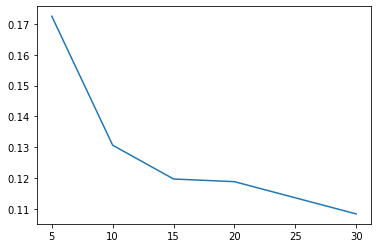

In [20]:
plt.plot(n_features, score)